In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import pymc as pm
import xarray as xr
import arviz as az
import utils as utils
from scipy import stats as stats
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import style
STYLE = "statistical-rethinking-2023.mplstyle"
style.use(STYLE)

In [3]:
df = utils.load_data("Howell1")
df["gender"] = np.where(df['male']==1, "male", "female")
# df.drop(columns=['male'], inplace=True)
df.head()

,height,weight,age,male,gender
0,151.765,47.825606,63.0,1,male
1,139.700,36.485807,63.0,0,female
2,136.525,31.864838,65.0,0,female
3,156.845,53.041914,41.0,1,male
4,145.415,41.276872,51.0,0,female


In [4]:
filt = df['age'] >= 18
df_adults = df[filt]

<Axes: xlabel='height', ylabel='weight'>

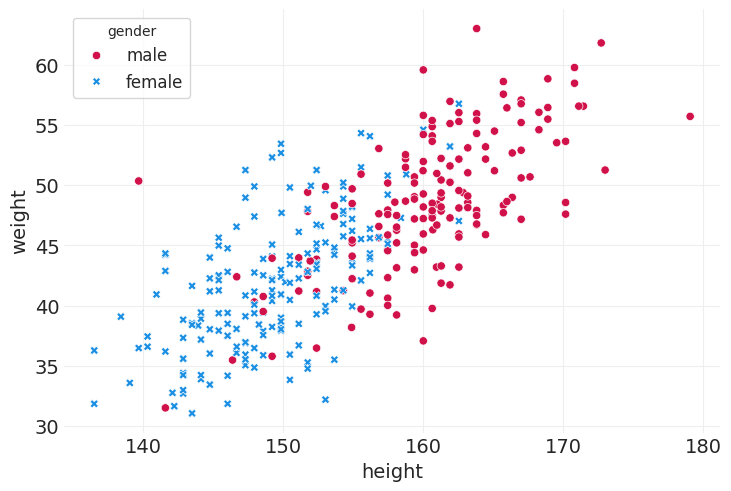

In [5]:
sns.scatterplot(data=df_adults, x="height", y="weight", hue='gender', style="gender")

Text(0.5, 1.0, 'Height, Adults')

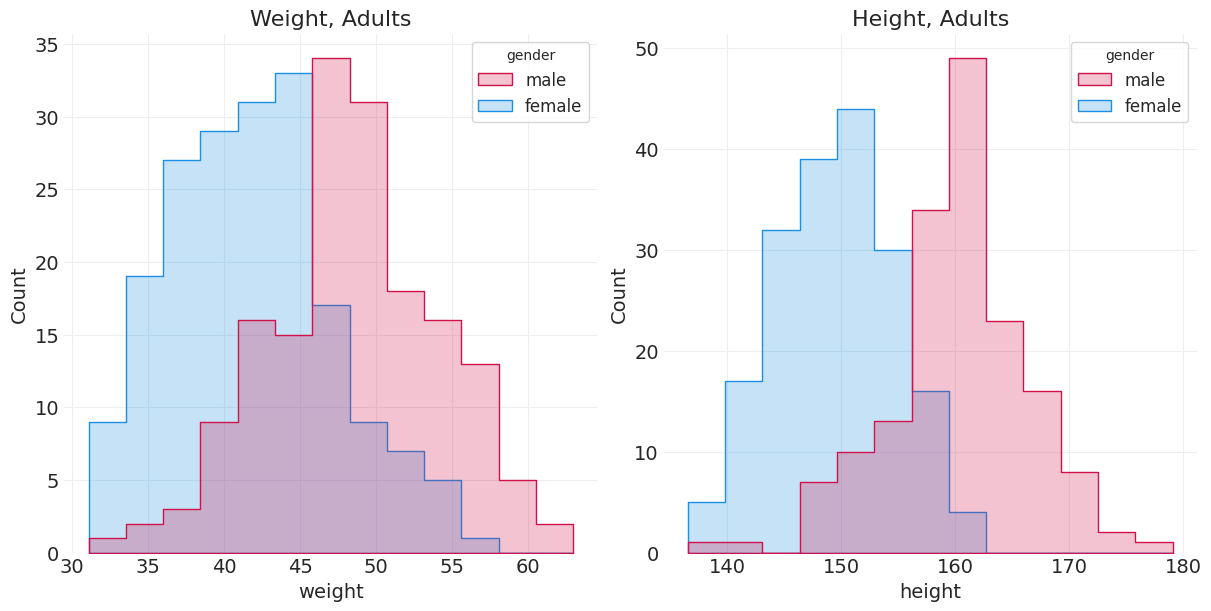

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.histplot(data=df_adults, x='weight', hue="gender", element='step', ax=ax[0])
ax[0].set_title("Weight, Adults")
sns.histplot(data=df_adults, x='height', hue="gender", element='step', ax=ax[1])
ax[1].set_title("Height, Adults")

# GENERATE SYNTHETIC PEOPLE

In [7]:
s=0 # female
s=1 # male

def sim_HW(S,b=np.array([0.5,0.6]),a=np.array([0,0])):
    N = len(S)
    
    H = np.where(S==1, 160.0, 150.0) + np.random.normal(loc=0, scale=5, size=N)
    
    W = a[S] + b[S]*H + np.random.normal(loc=0, scale=5, size=N)
    
    return pd.DataFrame({"height": H, "weight": W, "male": S})

In [8]:
synthetic_sexes = stats.bernoulli(p=.5).rvs(size=100).astype(int)

In [9]:
sim_HW(S=synthetic_sexes)

,height,weight,male
0,160.581263,99.460088,1
1,152.515325,75.632815,0
2,148.904787,77.370819,0
3,142.628638,79.512092,0
4,158.663801,86.284985,0
...,...,...,...
95,156.011068,82.049016,0
96,163.686774,96.153073,1
97,158.970278,97.963871,1
98,164.090624,98.291774,1


#### Causal effect of $H$ on $W$ (Q1)

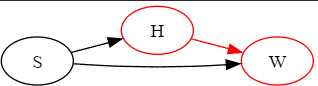

#### **Total** Causal effect of $S$ on $W$ (Q2)
* Both Sex and Height influence WEIGHT

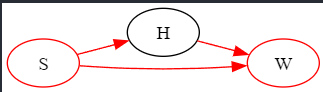

#### **Direct** Causal effect of $S$ on $W$ (Q3)

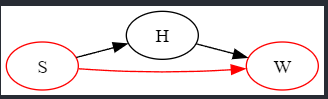

What we want to do is **stratify** by **sex** to get a different estimate (association) between sex and weight and sex and height for each s value in the data

We will be using index variables, NOT dummy variables

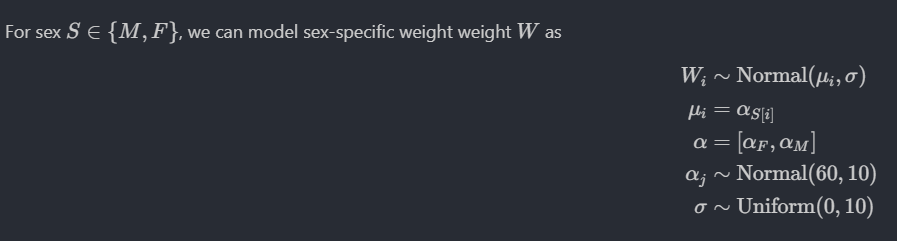

# TESTING
* What we want to do is find the total causal effect of **sex** through both paths
    * We construct **two** samples: one where everyone is female and the second where everyone is male.
    * Then we look at the average difference in weight
* What is the total causal effect of sex? What is the Causal effect of sex is difference made by intervening:

height     8.987315
weight    21.158389
male       1.000000
dtype: float64

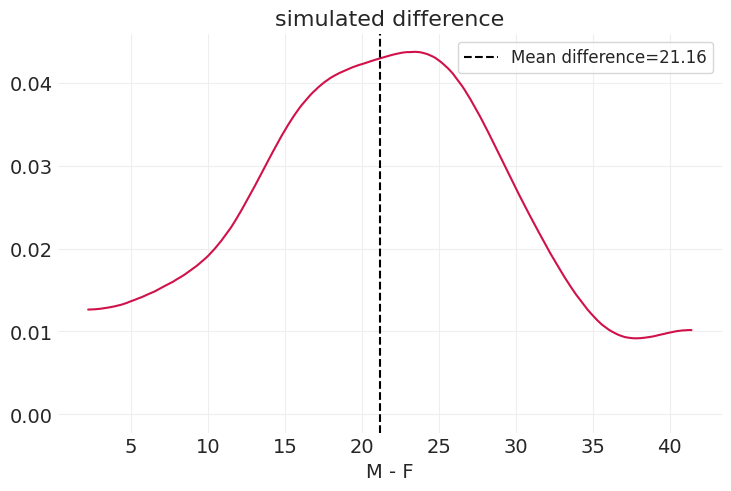

In [10]:
np.random.seed(12345)
n_simulations = 100

simulated_females = sim_HW(
    S=np.zeros(n_simulations).astype(int),
    b=np.array((0.5, 0.6))
)

simulated_males = sim_HW(
    S=np.ones(n_simulations).astype(int),
    b=np.array((0.5, 0.6))
)

simulated_delta = simulated_males - simulated_females
mean_simulated_delta = simulated_delta.mean()

az.plot_dist(simulated_delta['weight'].values)
plt.axvline(
    mean_simulated_delta['weight'],
    linestyle='--',
    color='k',
    label="Mean difference" + f"={mean_simulated_delta['weight']:1.2f}"
)
plt.xlabel("M - F")
plt.legend()
plt.title("simulated difference");

mean_simulated_delta

So now we see that the mean difference in weight between the male and the female sample for these parameter values is 21.16 kg
* And so this is what we want to be able to find when we **test** our estimator.
* So then later we can come back here and change parameter values, do the simulation again and test it on the estimator

# Fit the model on the synthetic sample

In [11]:
SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in df["male"].values])

C:\Users\Kuba\AppData\Local\Temp\ipykernel_3292\2393764784.py:1: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in df["male"].values])


In [12]:
def fit_total_effect_model(data):

    SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in data["male"].values])

    with pm.Model(coords={"SEX": SEX}) as model:
        # Data
        S = pm.MutableData("S", SEX_ID)

        # Priors
        sigma = pm.Uniform("sigma", 0, 10)
        alpha = pm.Normal("alpha", 60, 10, dims="SEX")

        # Likelihood
        mu = alpha[S]
        pm.Normal("W_obs", mu, sigma, observed=data["weight"])

        inference = pm.sample()
        
    return inference, model

# Concatentate simulations and code sex
simulated_people = pd.concat([simulated_females, simulated_males])
simulated_total_effect_inference, simulated_total_effect_model = fit_total_effect_model(simulated_people)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_3292\4096616940.py:3: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in data["male"].values])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [13]:
simulated_summary = az.summary(simulated_total_effect_inference, var_names=['alpha', 'sigma'])
simulated_delta = (simulated_summary.iloc[1] - simulated_summary.iloc[0])['mean']
print(f"Delta in average sex-specific weight: {simulated_delta:1.2f}")

simulated_summary

Delta in average sex-specific weight: 21.05


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[F],74.869,0.594,73.775,76.000,0.012,0.009,2346.0,1272.0,1.0
alpha[M],95.917,0.589,94.785,96.979,0.012,0.009,2246.0,1531.0,1.0
sigma,5.924,0.297,5.370,6.477,0.006,0.004,2637.0,1284.0,1.0


In [14]:
simulated_total_effect_inference['posterior']["alpha"].sel(SEX="F").mean()

<xarray.DataArray 'alpha' ()>
array(74.86940398)
Coordinates:
    SEX      <U1 'F'

In [15]:
simulated_total_effect_inference['posterior']["alpha"].sel(SEX="M").mean()

<xarray.DataArray 'alpha' ()>
array(95.91707311)
Coordinates:
    SEX      <U1 'M'

# POSTPROCESSING
* usually the unknowns themselves is not what we want. So the alpha[F], alpha[M] is not what we are after
* We have to do comparisons of these posterior distributions to get what we want
* Let's consider thinking about the difference in mean weight
* So we want to look at the contrast - that is the difference between category 1 and category 2. We use the whole posterior
* Always be constrasting!
    * Compute contrast of the alphas and posterior predictive

In [39]:
# Plotting helper functions
def plot_model_posterior(inference, effect_type: str = "Total"):
    np.random.seed(123)
    sex = ['F', 'M']
    posterior = inference.posterior

    fig, axs = plt.subplots(2, 2, figsize=(7, 7))

    # Posterior mean
    plt.sca(axs[0][0])
    for ii, s in enumerate(sex):
        posterior_mean = posterior["alpha"].sel(SEX=s).mean(dim='chain')
        az.plot_dist(posterior_mean, color=f"C{ii}", label=s, plot_kwargs=dict(linewidth=3))

    plt.xlabel("posterior mean weight (kg)")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior $\\alpha_S$")

    # Posterior Predictive
    plt.sca(axs[0][1])
    posterior_prediction_std = posterior["sigma"].mean(dim=['chain'])
    posterior_prediction = {}

    for ii, s in enumerate(sex):
        posterior_prediction_mean = posterior.sel(SEX=s)["alpha"].mean(dim=['chain'])
        posterior_prediction[s] = stats.norm.rvs(posterior_prediction_mean, posterior_prediction_std)
        az.plot_dist(posterior_prediction[s], color=f"C{ii}", label=s, plot_kwargs=dict(linewidth=3))

    plt.xlabel("posterior predicted weight (kg)")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior Predictive")

    # Plost Contrasts
    ## Posterior Contrast
    plt.sca(axs[1][0])
    posterior_contrast = posterior.sel(SEX='M')["alpha"] - posterior.sel(SEX='F')["alpha"]
    az.plot_dist(posterior_contrast, color='k', plot_kwargs=dict(linewidth=3))
    plt.xlabel("$\\alpha_M$ - $\\alpha_F$ posterior mean weight contrast")
    plt.ylabel("density")
    plt.title("Posterior Contrast")

    ## Posterior Predictive Contrast
    plt.sca(axs[1][1])
    posterior_predictive_contrast = posterior_prediction['M'] - posterior_prediction['F']
    n_draws = len(posterior_predictive_contrast)
    kde_ax = az.plot_dist(posterior_predictive_contrast, color='k', bw=1, plot_kwargs=dict(linewidth=3))

    # Shade underneath posterior predictive contrast
    kde_x, kde_y = kde_ax.get_lines()[0].get_data()

    # Proportion of PPD contrast below zero
    neg_idx = kde_x < 0
    neg_prob = 100 * np.sum(posterior_predictive_contrast < 0) / n_draws
    plt.fill_between(
        x=kde_x[neg_idx],
        y1=np.zeros(sum(neg_idx)),
        y2=kde_y[neg_idx],
        color='C0',
        label=f"{neg_prob:1.0f}%"
    )

    # Proportion of PPD contrast above zero (inclusive)
    pos_idx = kde_x >= 0
    pos_prob = 100 * np.sum(posterior_predictive_contrast >= 0) / n_draws
    plt.fill_between(
        x=kde_x[pos_idx],
        y1=np.zeros(sum(pos_idx)),
        y2=kde_y[pos_idx],
        color='C1',
        label=f"{pos_prob:1.0f}%"
    )

    plt.xlabel("(M - F)\nposterior prediction contrast")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior\nPredictive Contrast");
    plt.suptitle(f"{effect_type} Causal Effect of Sex on Weight", fontsize=18)
                 
def plot_posterior_lines(data, inference, centered=False):
    plt.subplots(figsize=(6, 6))
    
    min_height = data.height.min()
    max_height = data.height.max()
    xs = np.linspace(min_height, max_height, 10)
    for ii, s in enumerate(['F', 'M']):
        sex_idx = data.male == ii
        utils.plot_scatter(
            xs=data[sex_idx].height,
            ys=data[sex_idx].weight,
            color=f"C{ii}",
            label=s
        )
            
        posterior_mean = inference.posterior.sel(SEX=s).mean(dim=('chain', 'draw'))
        posterior_mean_alpha = posterior_mean['alpha'].values
        posterior_mean_beta = getattr(posterior_mean, 'beta', pd.Series([0])).values
        
        if centered:
            pred_x = xs - data.height.mean()
        else:
            pred_x = xs

        ys = posterior_mean_alpha + posterior_mean_beta * pred_x
        utils.plot_line(xs, ys, label=None, color=f"C{ii}")

    # Model fit to both sexes simultaneously
    global_model = smf.ols("weight ~ height", data=data).fit()
    ys = global_model.params.Intercept + global_model.params.height * xs
    utils.plot_line(xs, ys, color="k", label='Unstratified\nModel')

    plt.axvline(
        data["height"].mean(),
        label='Average H',
        linewidth=0.5, linestyle='--', color='black'
    )
    plt.axhline(
        data["weight"].mean(),
        label='Average W',
        linewidth=1, linestyle='--', color='black'
    )
    plt.legend()
    plt.xlabel("height (cm), H")
    plt.ylabel("weight (kg), W");

    np.random.seed(123)
    sex = ['F', 'M']
    posterior = inference.posterior

    fig, axs = plt.subplots(2, 2, figsize=(7, 7))

    # Posterior mean
    plt.sca(axs[0][0])
    for ii, s in enumerate(sex):
        posterior_mean = posterior["alpha"].sel(SEX=s).mean(dim='chain')
        az.plot_dist(posterior_mean, color=f"C{ii}", label=s, plot_kwargs=dict(linewidth=3))

    plt.xlabel("posterior mean weight (kg)")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior $\\alpha_S$")

    # Posterior Predictive
    plt.sca(axs[0][1])
    posterior_prediction_std = posterior["sigma"].mean(dim=['chain'])
    posterior_prediction = {}

    for ii, s in enumerate(sex):
        posterior_prediction_mean = posterior.sel(SEX=s)["alpha"].mean(dim=['chain'])
        posterior_prediction[s] = stats.norm.rvs(posterior_prediction_mean, posterior_prediction_std)
        az.plot_dist(posterior_prediction[s], color=f"C{ii}", label=s, plot_kwargs=dict(linewidth=3))

    plt.xlabel("posterior predicted weight (kg)")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior Predictive")

    # Plost Contrasts
    ## Posterior Contrast
    plt.sca(axs[1][0])
    posterior_contrast = posterior.sel(SEX='M')["alpha"] - posterior.sel(SEX='F')["alpha"]
    az.plot_dist(posterior_contrast, color='k', plot_kwargs=dict(linewidth=3))
    plt.xlabel("$\\alpha_M$ - $\\alpha_F$ posterior mean weight contrast")
    plt.ylabel("density")
    plt.title("Posterior Contrast")

    ## Posterior Predictive Contrast
    plt.sca(axs[1][1])
    posterior_predictive_contrast = posterior_prediction['M'] - posterior_prediction['F']
    n_draws = len(posterior_predictive_contrast)
    kde_ax = az.plot_dist(posterior_predictive_contrast, color='k', bw=1, plot_kwargs=dict(linewidth=3))

    # Shade underneath posterior predictive contrast
    kde_x, kde_y = kde_ax.get_lines()[0].get_data()

    # Proportion of PPD contrast below zero
    neg_idx = kde_x < 0
    neg_prob = 100 * np.sum(posterior_predictive_contrast < 0) / n_draws
    plt.fill_between(
        x=kde_x[neg_idx],
        y1=np.zeros(sum(neg_idx)),
        y2=kde_y[neg_idx],
        color='C0',
        label=f"{neg_prob:1.0f}%"
    )

    # Proportion of PPD contrast above zero (inclusive)
    pos_idx = kde_x >= 0
    pos_prob = 100 * np.sum(posterior_predictive_contrast >= 0) / n_draws
    plt.fill_between(
        x=kde_x[pos_idx],
        y1=np.zeros(sum(pos_idx)),
        y2=kde_y[pos_idx],
        color='C1',
        label=f"{pos_prob:1.0f}%"
    )

    plt.xlabel("(M - F)\nposterior prediction contrast")
    plt.ylabel("density")
    plt.legend()
    plt.title("Posterior\nPredictive Contrast");
    plt.suptitle(f"{effect_type} Causal Effect of Sex on Weight", fontsize=18)

Plot on the upper left shows the posterior distribution for alpha for each category (Female and Male in our case)


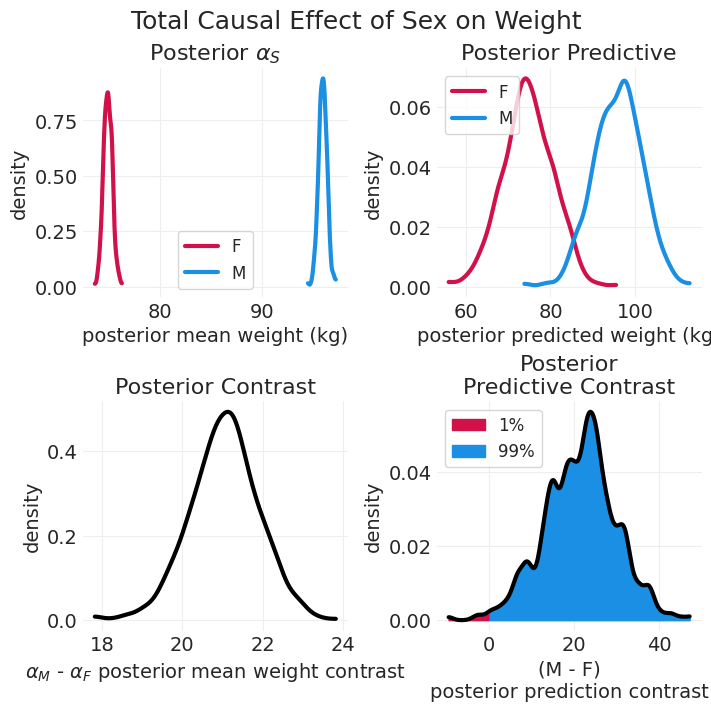

In [17]:
plot_model_posterior(simulated_total_effect_inference)

# ANALYZE REAL SAMPLE

In [18]:
adult_howell_total_effect_inference, adult_howell_total_effect_mod = fit_total_effect_model(df_adults)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_12284\4096616940.py:3: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in data["male"].values])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [19]:
adult_howell_total_effect_summary = az.summary(adult_howell_total_effect_inference, var_names=['alpha'])
adult_howell_total_effect_delta = (adult_howell_total_effect_summary.iloc[1] - adult_howell_total_effect_summary.iloc[0])['mean']
print(f"Delta in average sex-specific weight: {adult_howell_total_effect_delta:1.2f}")

adult_howell_summary = az.summary(adult_howell_total_effect_inference)
adult_howell_summary

Delta in average sex-specific weight: -6.75


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[M],48.598,0.431,47.849,49.450,0.008,0.006,2697.0,1425.0,1.0
alpha[F],41.843,0.405,41.129,42.639,0.008,0.005,2862.0,1357.0,1.0
sigma,5.521,0.206,5.163,5.920,0.004,0.003,2718.0,1501.0,1.0


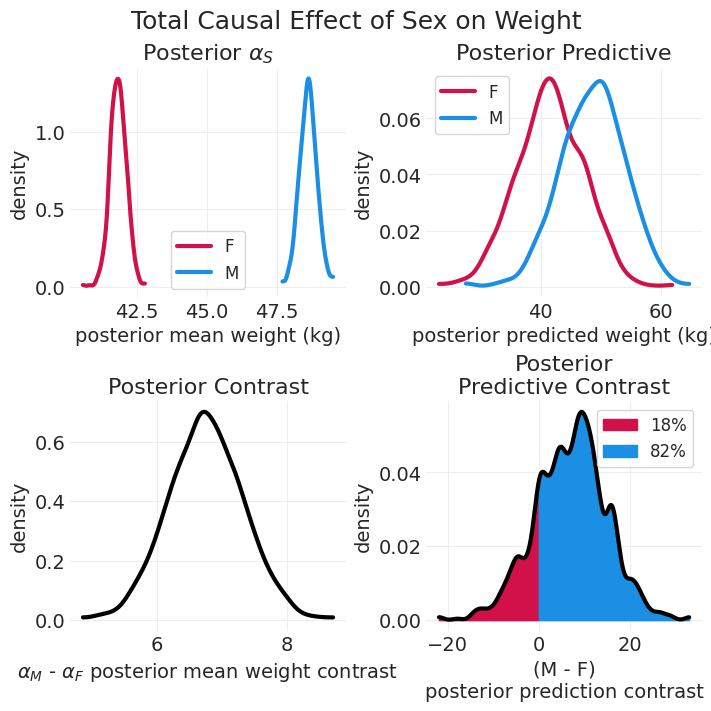

In [20]:
plot_model_posterior(adult_howell_total_effect_inference)

* So in here we see a lot of overlap in the posterior predictive distribution, but it doesnt mean that these distributions are the same
    * When we look at contrast we see the posterior of difference
    * And this is our knowledge about women and men in body weight in that sample
    * In the bottom right we have the individuals, so not the means. And it says that if we randomly select a man and woman, how often the man is going to be heavier than the woman, 82 % of the time
* These two contrast at the bottom answer the question of

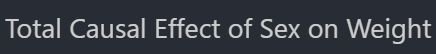

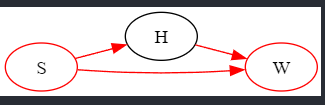

* Now we want to know the

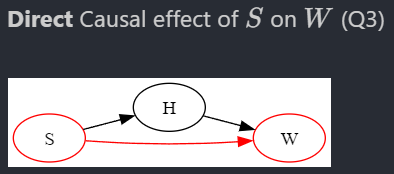

* And so now we need another model, because we need to somehow "block" the inderect effect of sex through height on weight
* We can stratify by H to statistically block the inderect influence of sex throught height on weight

In [28]:
np.random.seed(1234)
n_synthetic_people = 200
synthetic_sex = stats.bernoulli.rvs(p=.5, size=n_synthetic_people)

synthetic_people = sim_HW(S=synthetic_sex, b=np.array([0.5,0.5]), a=np.array([0, 10])) # Men heavier 10kg on avg, regardless of height
synthetic_people

,height,weight,male
0,153.143879,70.798935,0
1,160.932472,84.125891,1
2,154.762392,80.420507,0
3,164.940688,87.069862,1
4,159.636958,86.762071,1
...,...,...,...
195,155.393368,82.947252,0
196,161.703763,90.008386,1
197,149.009625,78.494195,0
198,172.407292,98.966268,1


c:\Users\Kuba\miniconda3\envs\statistical-rethinking-2023\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


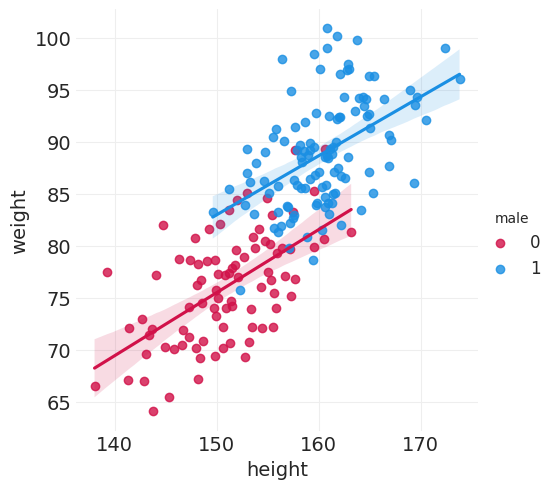

In [33]:
sns.lmplot(data=synthetic_people, x="height", y="weight", hue='male')

* How do we develop a model that estimates that bonus effect of sex, beyond what we would expect for their height
* We use a Linear Model
* Before we had an alpha intercept that was unique to each sex
* Now we update that model to include the height effect, because we want to stratify by height
* That means, including height as variable in the regression
* That allows the model to say:
    * For individuals that are the same height, what are the differences by category?

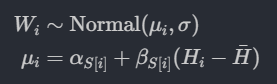

* What happened above in the brackets (Hi - H^) is called centering
* Hi is the centered height and H^ is the average height
* Why do we want centering?:
    * Centering Height makes it so that alpha is the average weight of a person with average height
    * Centering makes it easier to define priors for alpha

* So now we allow the slope to differ by sex and as before, the intercept:

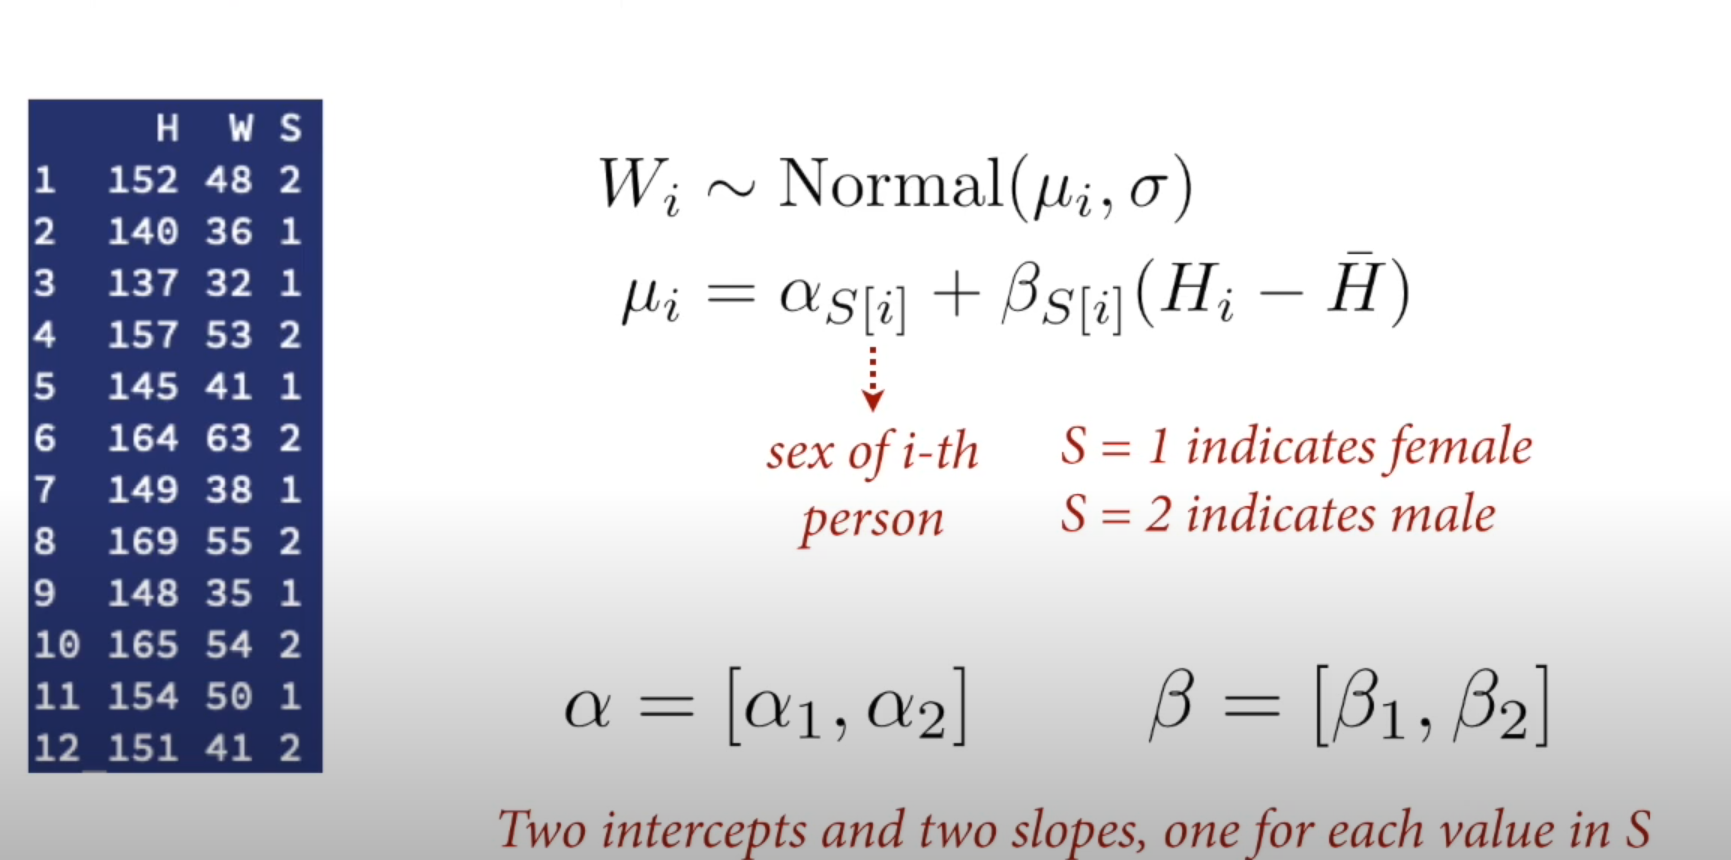

In [34]:
def fit_direct_effect_weight_model(data):

    SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in data["male"].values])

    with pm.Model(coords={"SEX": SEX}) as model:
        # Data
        S = pm.MutableData("S", SEX_ID, dims="obs_ids")
        H = pm.MutableData("H", data["height"].values, dims="obs_ids")
        Hbar = pm.MutableData("Hbar", data["height"].mean())

        # Priors
        sigma = pm.Uniform("sigma", 0, 10)
        alpha = pm.Normal("alpha", 60, 10, dims="SEX")
        beta = pm.Uniform("beta", 0, 1, dims="SEX")  # postive slopes only

        # Likelihood
        mu = alpha[S] + beta[S] * (H - Hbar)
        pm.Normal("W_obs", mu, sigma, observed=data["weight"].values, dims="obs_ids")

        inference = pm.sample()
        
    return inference, model

In [35]:
direct_effect_simulated_inference, direct_effect_simulated_model = fit_direct_effect_weight_model(data=synthetic_people)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_12284\4172879565.py:3: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in data["male"].values])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


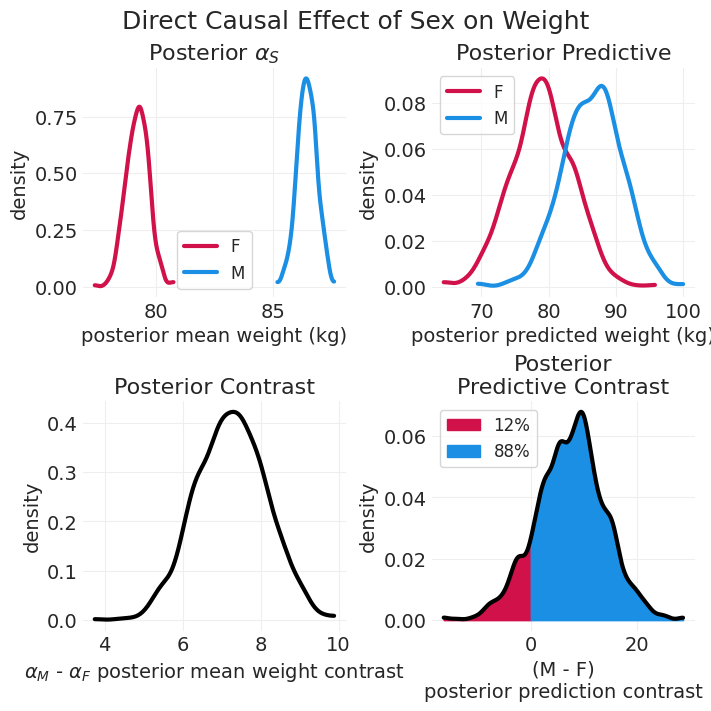

In [36]:
plot_model_posterior(direct_effect_simulated_inference, "Direct")

## Analyze the real sample

In [37]:
direct_effect_howell_inference, direct_effect_howell_model = fit_direct_effect_weight_model(df_adults)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_12284\4172879565.py:3: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  SEX_ID, SEX = pd.factorize(["M" if s else "F" for s in data["male"].values])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


NameError: name 'effect_type' is not defined

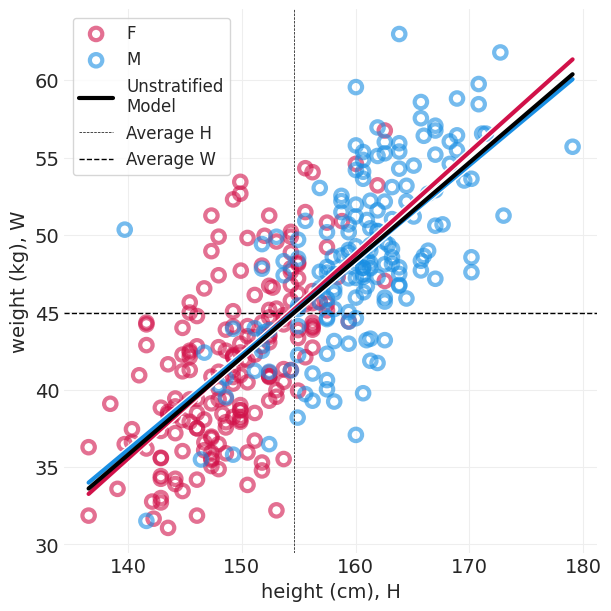

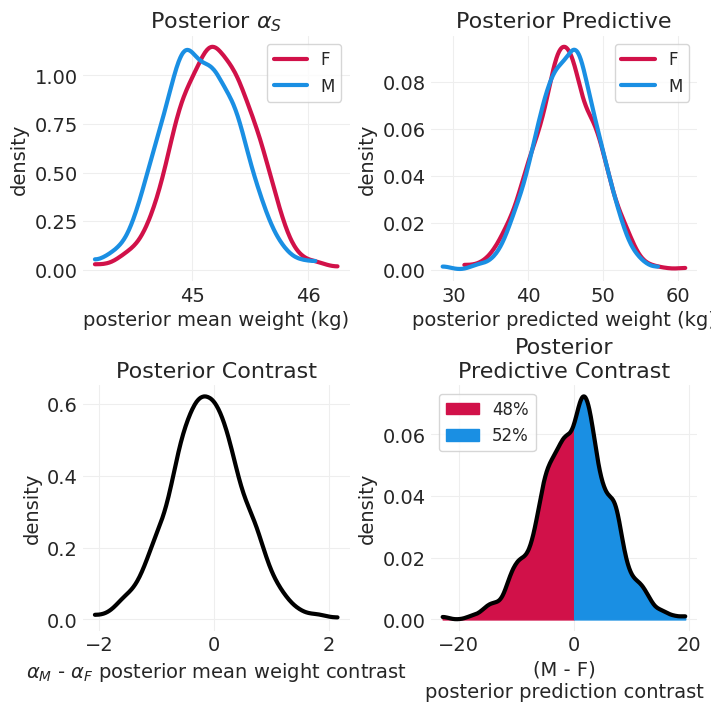

In [41]:
plot_posterior_lines(df_adults, direct_effect_howell_inference, True)

In [42]:
def plot_heightwise_contrast(model, inference):
    heights = np.linspace(130, 190, 100)
    ppds = {}
    for ii, s in enumerate(['F', 'M']):
        with model:
            pm.set_data(
                {
                    "S": np.ones_like(heights).astype(int) * ii,
                    "H": heights,
                    "Hbar": heights.mean()
                }
            )
            ppds[s] = pm.sample_posterior_predictive(inference, extend_inferencedata=False).posterior_predictive["W_obs"]

    ppd_contrast = ppds['M'] - ppds['F']
    
    # Plot contours
    for prob in [.5, .75, .95, .99]:
        az.plot_hdi(heights, ppd_contrast, hdi_prob=prob, color='gray')

    plt.axhline(0, linestyle='--', color='k');
    plt.xlabel("height, H (cm)")
    plt.ylabel("weight W contrast (M-F)")
    plt.xlim([130, 190])


Sampling: [W_obs]


Sampling: [W_obs]


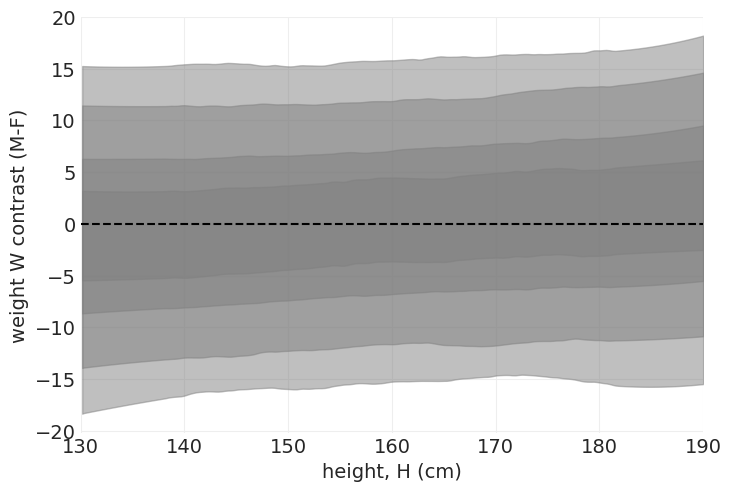

In [43]:
plot_heightwise_contrast(direct_effect_howell_model, direct_effect_howell_inference)

# CURVES FROM LINES
* Almost all relationships are not linear

<Axes: xlabel='height', ylabel='weight'>

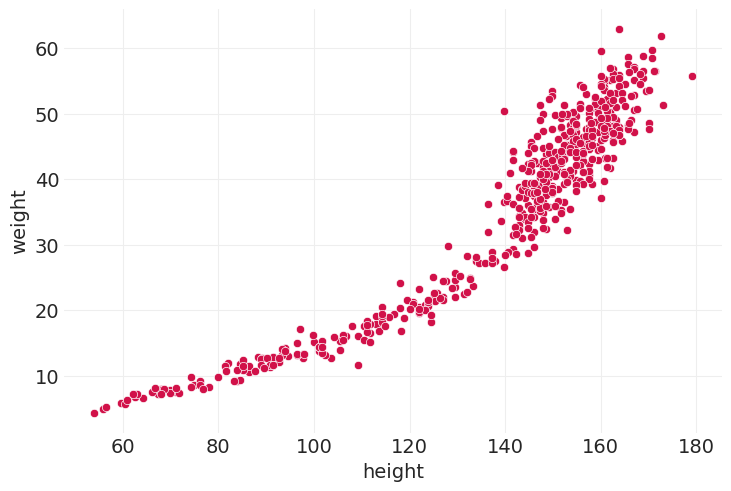

In [15]:
import seaborn as sns
sns.scatterplot(data=df, x="height", y="weight")

#### Turns out using polynomials may not be a good strategy
* They are not scientifically reasonable
* Uncertainty is expressed explosively at the edges of the data
* The reason for these is that any point in any point in the X axis can change the shape of the curve far from where it is
    * It is called global smoothing, not local smoothing, which is what we want and will achieve with splines
* Essentially for me, the main takeaway is:
    * We cant make reasonable predictions for X values *outside* of the range of X values the model was trained on

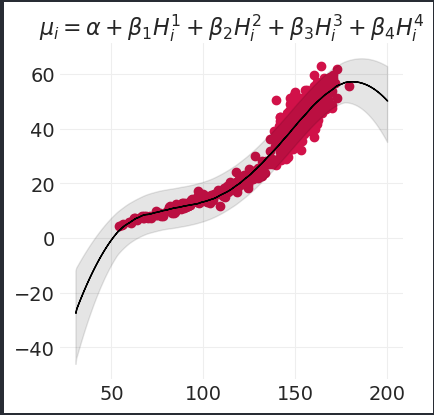

###  SPLINES 

,year,doy,temp,temp_upper,temp_lower
11,812,92.0,NaN,NaN,NaN
14,815,105.0,NaN,NaN,NaN
30,831,96.0,NaN,NaN,NaN
50,851,108.0,7.38,12.1,2.66
52,853,104.0,NaN,NaN,NaN


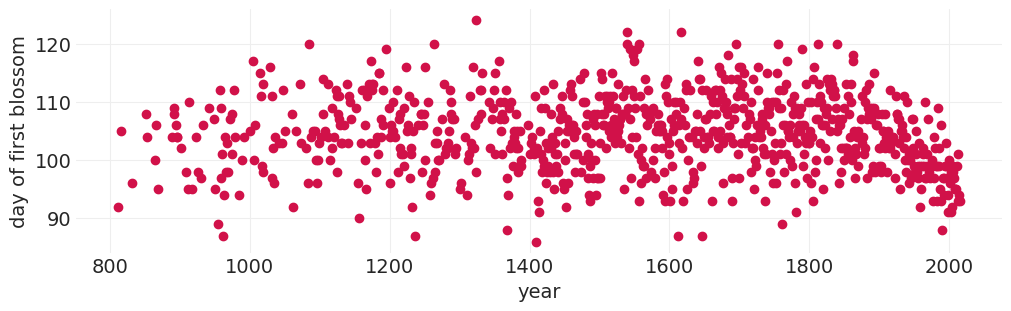

In [16]:
BLOSSOMS = utils.load_data("cherry_blossoms")
BLOSSOMS.dropna(subset=["doy"], inplace=True)
plt.subplots(figsize=(10, 3))
plt.scatter(
    x=BLOSSOMS.year,
    y=BLOSSOMS.doy
)
plt.xlabel("year")
plt.ylabel("day of first blossom")
BLOSSOMS.head()

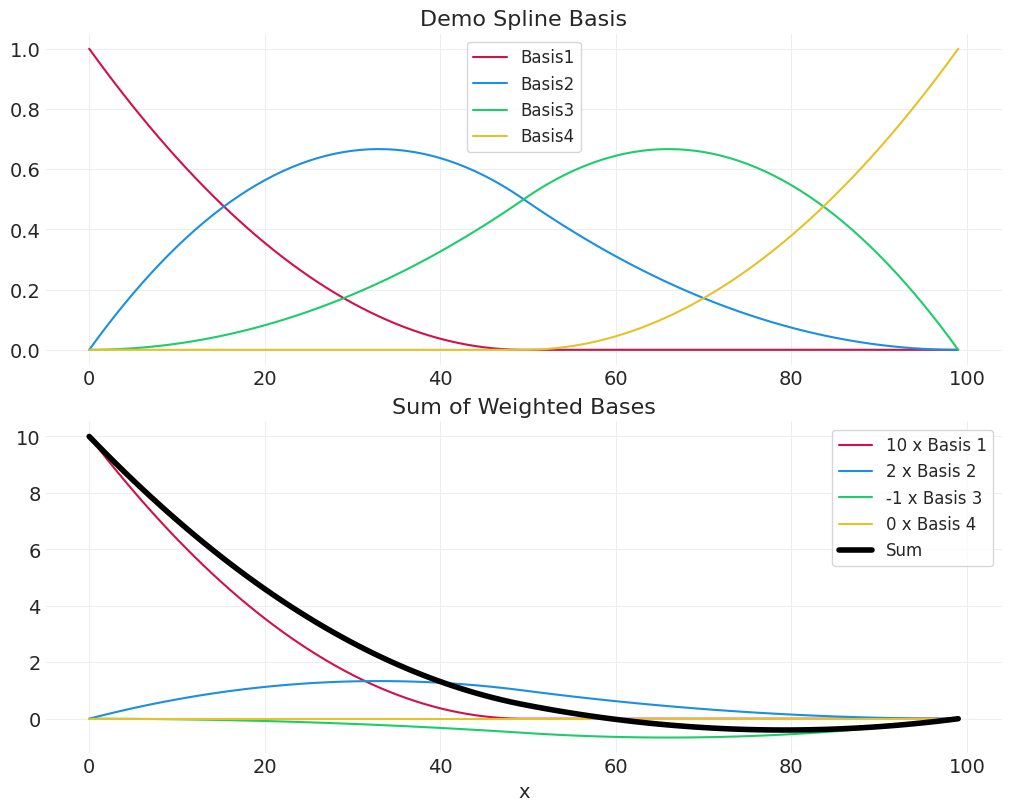

In [18]:
from patsy import dmatrix

def generate_spline_basis(data, xdim='year', degree=2, n_bases=10):
    n_knots = n_bases - 1
    knots = np.quantile(data[xdim], np.linspace(0, 1, n_knots))
    return dmatrix(
        f"bs({xdim}, knots=knots, degree={degree}, include_intercept=True) - 1",
        {xdim: data[xdim], "knots": knots[1:-1]}
    )
    
# 4 spline basis for demo
demo_data = pd.DataFrame({"x": np.arange(100)})
demo_basis = generate_spline_basis(demo_data, "x", n_bases=4)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.sca(axs[0])
for bi in range(demo_basis.shape[1]):
    plt.plot(demo_data.x, demo_basis[:, bi], color=f"C{bi}", label=f'Basis{bi+1}')
plt.legend();
plt.title("Demo Spline Basis")

# Arbitrarily-set weights for demo
basis_weights = [10, 2, -1, 0]

plt.sca(axs[1])
resulting_curve = np.zeros_like(demo_data.x)
for bi in range(demo_basis.shape[1]):
    weighted_basis = demo_basis[:, bi] * basis_weights[bi]
    resulting_curve = resulting_curve + weighted_basis
    plt.plot(demo_data.x, weighted_basis, color=f"C{bi}", label=f'{basis_weights[bi]} x Basis {bi+1}')
plt.plot(demo_data.x, resulting_curve, label='Sum', color='k', linewidth=4)
plt.xlabel("x")
plt.legend();
plt.title("Sum of Weighted Bases");